# Wzbogacanie danych i przenoszenie uczenia
Wraz ze wzrostem liczby parametrów sieci problemem na powrót stał się brak danych. Występował on wcześniej, min. przy sieciach gęstych, gdzie, aby nauczyć takie rozwiązanie potrzeba było podczas treningu podać niemalże wszystkie możliwe kombinacje danych. Wtedy rozwiązaniem okazało się wprowadzenie sieci splotowych, w których perceptrony zgromadzono w przesuwające się po danych wejściowych oknach, dzięki temu stało się możliwe wykorzystywanie tych samych wyuczonych elementów w stosunku do dowolnego fragmentu obrazu.

Nowe podejście do wspomnianego problemu jest realizowane dwutorowo. Po pierwsze generuje się dodatkowe obrazy, na podstawie tych już istniejących w zbiorze, dzięki czemu algorytm ma więcej informacji o tym, które cech sa istotne, a które nie. Te elementy, które w dodanych obrazach pozostają niezmienne, klasyfikator traktuje jako istotne, natomiast te, które się zmieniają, ignoruje. Drugim sposobem jest kopiowanie wyuczonych fragmentów sieci, co jest możliwe, dzięki temu, że część zdolności, które musi nabyć klasyfikator, jest w dużej mierze niezależna od konkretnego problemu. Z drugiej strony te zdolności często wymagają sporej ilości obliczeń i danych przy treningu, co daje dodatkowe korzyści, a w niektórych przypadkach, w szczególności, gdy występuje problem braku wystarczającej liczby różnorodnych przykładów, w ogóle umożliwia skuteczny trening.

Jeden z tego typu problemów jest przedmiotem niniejszego ćwiczenia. Zbiór Fashion-MNIST zawiera dużą liczbę, w zbliżony sposób wykonanych fotografii. Jest to stosunkowo łatwy zbiór do osiągnięcia na nim wysokiej skuteczności, nawet dla małych sieci typu LeNet-5, ale z powodu na niską różnorodność, wytrenowane na nim modele słabo adaptują się do obrazów naturalnych. Aby zaradzić temu problemowi, w niniejszym ćwiczeniu wykorzystano wagi wyliczone na podstawie zbioru ImageNet. W związku z tym głównym wyzwaniem pozostaje takie dostosowanie klasyfikatora do nowego problemu, aby nie utracić wcześniej nabytych zdolności.

## Zależności

In [22]:
import numpy as np
import time

import PIL.Image as Image
import PIL.ImageOps    
import matplotlib.pylab as plt

import tensorflow as tf
import tf_keras as keras
import tensorflow_hub as hub
from keras import datasets

import datetime
import os

%load_ext tensorboard

print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
2.15.1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Klasyfikator ImageNet
### Pobranie klasyfikatora

In [3]:
mobilenet_v2 ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4"
inception_v3 = "https://tfhub.dev/google/imagenet/inception_v3/classification/5"
resnet_v1 = "https://www.kaggle.com/models/google/resnet-v1/TensorFlow2/50-classification/2"

classifier_model = inception_v3

In [5]:
IMAGE_SIZE = 96
IMAGE_SHAPE = (IMAGE_SIZE, IMAGE_SIZE)

classifier = keras.Sequential([
    hub.KerasLayer(classifier_model, input_shape=IMAGE_SHAPE+(3,))
])

### Uruchomienie klasyfikatora na pojedyńczym obrazie

211086/211086 [==============================] - 0s 0us/step


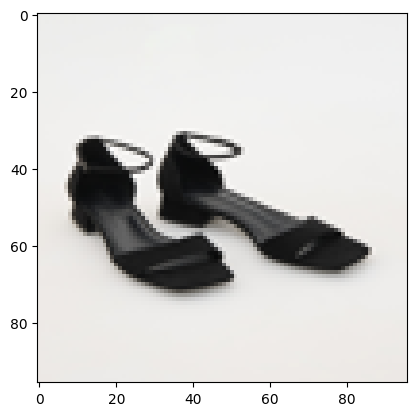

In [19]:
path = keras.utils.get_file('image.jpg','https://static.reserved.com/media/catalog/product/5/6/5698Y-99X-011-1-808148.jpg')

img = Image.open(path).resize((IMAGE_SIZE, IMAGE_SIZE))
os.remove(path)
plt.figure()
plt.imshow(img)
plt.grid(False)
plt.show()

In [7]:
SRC_SIZE=28
OFFSET=int((IMAGE_SIZE-SRC_SIZE)/2)
img = tf.image.resize(img, (SRC_SIZE, SRC_SIZE))
img = tf.image.pad_to_bounding_box(img, OFFSET, OFFSET, IMAGE_SIZE, IMAGE_SIZE)
img = np.array(img) / 255.0
img.shape

(96, 96, 3)

In [8]:
result = classifier.predict(img[np.newaxis, ...])
result.shape

2024-05-20 10:26:26.069855: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-05-20 10:26:27.430147: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


1/1 [==============================] - 26s 26s/step


(1, 1001)

In [15]:
predicted_class = tf.math.argmax(result[0], axis=-1)
predicted_class

<tf.Tensor: shape=(), dtype=int64, numpy=917>

### Dekodowanie predykcji

In [20]:
labels_path = keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

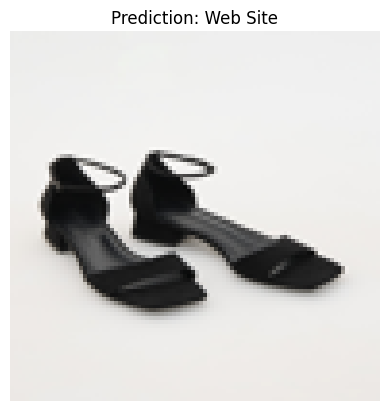

In [21]:
plt.imshow(img)
plt.axis('off')
predicted_class_name = imagenet_labels[predicted_class]
_ = plt.title("Prediction: " + predicted_class_name.title())

## Import i wstępne przygotowanie danych



In [23]:
(train_images, train_labels), (test_images, test_labels) = datasets.fashion_mnist.load_data()
train_images = train_images / 255.0
test_images = test_images / 255.0

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

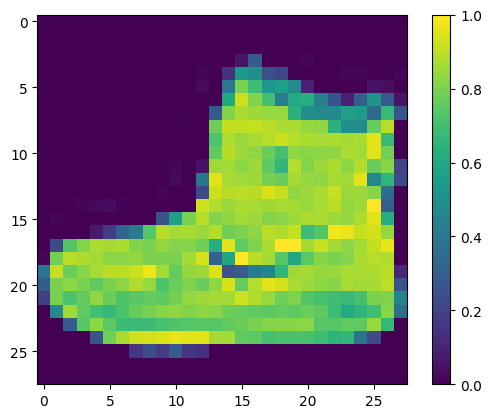

(28, 28, 1)


In [24]:
plt.figure()
plt.imshow(train_images[0])
plt.colorbar()
plt.grid(False)
plt.show()

input_shape = train_images[0].shape
if len(input_shape) < 3:
    input_shape += tuple([1])
print(input_shape)

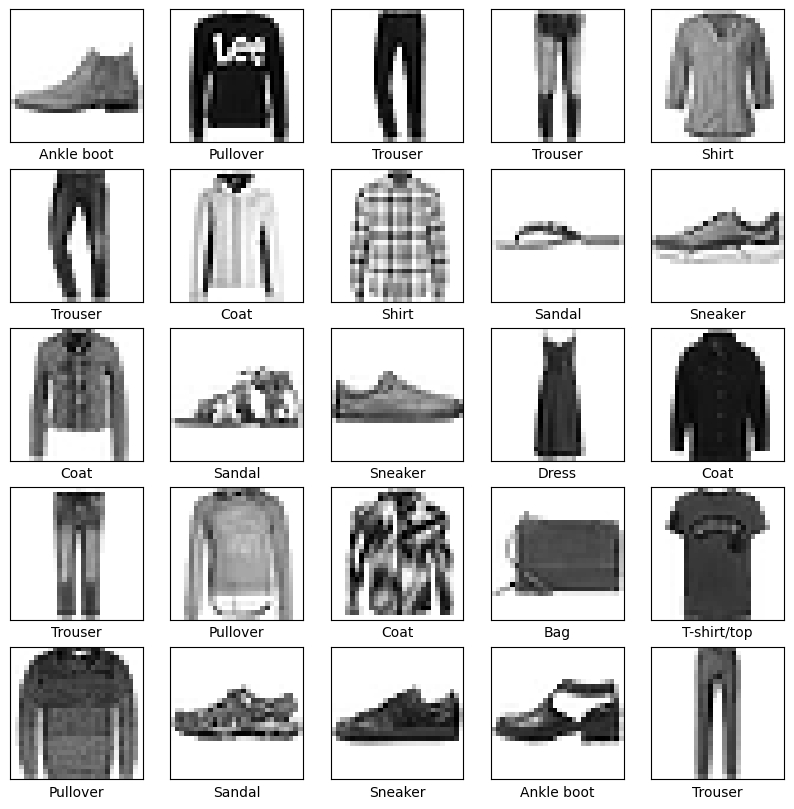

In [25]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(test_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[test_labels[i]])
plt.show()

## Zadania
1. Wybierz z Internetu co najmniej kilka fotografii, należących do klas ze zbioru Fasion-MNIST, zbuduj z nich niewielki zbiór testowy do sprawdzania modeli. Zadbaj, aby znalazły się w nim zarówno przykłady należące do klas, które mają swoją reprezentację w obu zbiorach treningowych (sandal, T-shirt) jak też take, które występują tylko w Fashion-MNIST. (1 pkt)
2. Dostosuj rozmiar własnych danych wejściowych do zbioru Fashion-MNIST. W tym celu zmień rozmiar wejścia klasyfikatora na najmniejszy możliwy (96 na 96), a obrazy przeskaluj formatu identycznego, z tym zastosowanym w Fashion-MNIST, z wyjątkiem liczby kanałów. (1 pkt)
3. Dodaj modyfikacje danych polegające na losowych zmianach rozmiaru i położenia. (1 pkt)
4. W zbiorze Fashion-MNIST wszystkie obrazy są monochromatyczne. Wzbogać je o kolory. (1 pkt)
5. Pobierz wersję modelu bez klasyfikatora i wytrenuj go na zbiorze Fashion-MNIST. (1 pkt)

## Źródła
https://www.tensorflow.org/tutorials/images/transfer_learning_with_hub
